In [2]:
import os
from joblib import dump
from pathlib import Path

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import numpy as np

from imblearn.over_sampling import SMOTE
import time
from scipy.stats import loguniform, randint
from yellowbrick.model_selection import RFECV
from scipy.stats import loguniform, randint
from sklearn.model_selection import RandomizedSearchCV
import warnings
from yellowbrick.model_selection import RFECV
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

In [3]:
start_time = time.time()


In [4]:
# Set up directory
os.chdir("/home/siti/Downloads/New Modelling")

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('AE_Synthetic_Data_Final_V02.csv')

In [5]:
print(df["LOS_Category"].value_counts())

Short stay    11942983
Long stay       779233
Name: LOS_Category, dtype: int64


In [6]:
results_folder = Path("DT_folder/Version 2/Model 3")
results_folder.mkdir(parents=True, exist_ok=True) 

# Feature Engineering

## 1. AE_Arrive_HourOfDay

In [7]:
# Define a function to map the time bands to categories
def categorize_time_band(band):
    if band in ['05-08', '09-12']:
        return 'Morning'
    elif band in ['13-16', '17-20']:
        return 'Evening'
    else:  # '01-04', '21-24'
        return 'Night'

# Apply the function to the Time_band column
df['AE_Arrive_HourOfDay'] = df['AE_Arrive_HourOfDay'].apply(categorize_time_band)

print(df.head())

        IMD_Category Age_Band     Sex AE_Arrive_HourOfDay  AE_Time_Mins  \
0  Most deprived 20%    65-84    Male             Evening           210   
1          20% - 40%      85+  Female             Evening           240   
2          60% - 80%    65-84  Female             Morning           160   
3  Most deprived 20%    65-84    Male             Evening           310   
4  Most deprived 20%    45-64    Male             Evening           210   

    AE_HRG  AE_Num_Diagnoses  AE_Num_Investigations  AE_Num_Treatments  \
0     High                 1                      5                  3   
1      Low                 1                     10                 10   
2  Nothing                 0                      1                  1   
3      Low                 0                      1                  3   
4     High                 4                      4                  4   

  AE_Arrival_Mode ICD10_Chapter_Code    TFC LOS_Category  
0       Not known              XVIII    180  

# 2. Number of Treatments

In [8]:
# Number of Treatments

# low : 0, 1, 2
# Medium : 3, 4
# high = 10,  7,  6,  5,  8,  9

df['AE_Num_Treatments_Cat'] = pd.qcut(df['AE_Num_Treatments'], q=3, labels=["low", "medium", "high"])


proportions = df['AE_Num_Treatments_Cat'].value_counts(normalize=True)

print(proportions)

low       0.459667
medium    0.282128
high      0.258205
Name: AE_Num_Treatments_Cat, dtype: float64


## 3. Number of Investigation

In [9]:

# Number of Investigation

# low : [1, 2, 3, 0]
# Medium : [5, 4, 6]
# high = [10,  8,  7,  9])

df['AE_Num_Investigations_Cat'] = pd.qcut(df['AE_Num_Investigations'], q=3, labels=["low", "medium", "high"])


proportions = df['AE_Num_Investigations_Cat'].value_counts(normalize=True)

print(proportions)

low       0.370985
medium    0.352462
high      0.276553
Name: AE_Num_Investigations_Cat, dtype: float64


## 4. Number of Diagnoses

Given the distribution's skewness, it might make sense to use custom bins:

- 0 as its own bin (e.g., 'none')
- 1 as its own bin (e.g., 'low')
- 2-3 (or 2-4) as a medium range
- 5-10 as a high range

This approach considers the data's natural concentration around 0 and 1 while still differentiating between medium and higher values.

In [10]:
# Number of Investigations

# count    1.272222e+07
# mean     9.066763e-01
# std      7.732276e-01
# min      0.000000e+00
# 25%      1.000000e+00
# 50%      1.000000e+00
# 75%      1.000000e+00
# max      1.000000e+01


def custom_bin(value):
    if value == 0:
        return 'none'
    elif value == 1:
        return 'low'
    elif 1 < value <= 4:
        return 'medium'
    else:
        return 'high'

df['AE_Num_Diagnoses_Cat'] = df['AE_Num_Diagnoses'].apply(custom_bin)

print(df['AE_Num_Diagnoses_Cat'].value_counts(normalize=True))


low       0.646599
none      0.242790
medium    0.106717
high      0.003894
Name: AE_Num_Diagnoses_Cat, dtype: float64


- About half of the patients live Close (0-3 miles) to the provider.
- A little over a quarter live at a Moderate distance (4-7 miles).
- About 17% are Far (8-15 miles).
- And around 6.5% are Very Far (>15 miles).

In [11]:
# Drop the original columns after caetgorizing number of treatments and diagnoses
df2 = df.drop(['AE_Num_Investigations', 'AE_Num_Treatments', 'AE_Num_Diagnoses'], axis=1)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12722216 entries, 0 to 12722215
Data columns (total 13 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   IMD_Category               object  
 1   Age_Band                   object  
 2   Sex                        object  
 3   AE_Arrive_HourOfDay        object  
 4   AE_Time_Mins               int64   
 5   AE_HRG                     object  
 6   AE_Arrival_Mode            object  
 7   ICD10_Chapter_Code         object  
 8   TFC                        object  
 9   LOS_Category               object  
 10  AE_Num_Treatments_Cat      category
 11  AE_Num_Investigations_Cat  category
 12  AE_Num_Diagnoses_Cat       object  
dtypes: category(2), int64(1), object(10)
memory usage: 1.1+ GB


In [12]:
# Convert object types to category
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [13]:
# Create a copy of df for modelling
data = df2.copy()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12722216 entries, 0 to 12722215
Data columns (total 13 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   IMD_Category               object  
 1   Age_Band                   object  
 2   Sex                        object  
 3   AE_Arrive_HourOfDay        object  
 4   AE_Time_Mins               int64   
 5   AE_HRG                     object  
 6   AE_Arrival_Mode            object  
 7   ICD10_Chapter_Code         object  
 8   TFC                        object  
 9   LOS_Category               object  
 10  AE_Num_Treatments_Cat      category
 11  AE_Num_Investigations_Cat  category
 12  AE_Num_Diagnoses_Cat       object  
dtypes: category(2), int64(1), object(10)
memory usage: 1.1+ GB


In [14]:
# Define the features and target
feature_cols = data.columns[data.columns != 'LOS_Category']
X = data[feature_cols]
y = data['LOS_Category']


# Step 1: Map the Outcome Variable

In [15]:
y = y.map({'Short stay': 1, 'Long stay': 0})

In [16]:
print(y.value_counts())

1    11942983
0      779233
Name: LOS_Category, dtype: int64


# Step 2: Split Data

In [17]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y) 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

**Overall Proportions:**

- **Test set**: 15% of the original dataset
- **Validation set**: 0.1765 * 0.85 = 0.15 or 15% of the original dataset
- **Training set**: 1−0.15−0.15 = 0.7 or 70% of the original dataset

So, by using this two-step splitting, we've achieved a 70-15-15 split for the training, validation, and test datasets, respectively.

# Identify Skewed Variables

In [18]:
# Identify skewed columns (assuming numeric columns)
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
skewed_features = X_train[numeric_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_features})
skewed_cols = skewness[abs(skewness) > 0.5].index

print(skewed_cols)

Index(['AE_Time_Mins'], dtype='object')


In [19]:
# Apply log transformation to 'AE_Time_Mins' for training data
X_train['AE_Time_Mins'] = np.log1p(X_train['AE_Time_Mins'])

# Apply log transformation to 'AE_Time_Mins' for testing data
X_test['AE_Time_Mins'] = np.log1p(X_test['AE_Time_Mins'])

# Apply log transformation to 'AE_Time_Mins' for validation data
X_val['AE_Time_Mins'] = np.log1p(X_val['AE_Time_Mins'])

# Step 3: One-Hot Encoding 

In [20]:
# Your nominal columns
nominal_columns = ['Sex', 'AE_Arrival_Mode', 'ICD10_Chapter_Code', 'TFC', 'AE_Arrive_HourOfDay']

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=nominal_columns, drop_first=True)
X_val = pd.get_dummies(X_val, columns=nominal_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=nominal_columns, drop_first=True)

# Get all columns in X_train after one-hot encoding
all_columns = X_train.columns

# Ensure X_val has the same columns as X_train
for col in all_columns:
    if col not in X_val.columns:
        X_val[col] = 0

# Ensure X_test has the same columns as X_train
for col in all_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Reorder columns in X_val and X_test to match X_train's order
X_val = X_val[all_columns]
X_test = X_test[all_columns]

# Step 4: Ordinal Encoding

In [21]:
orders = {
    'IMD_Category': ['Most deprived 20%', '20% - 40%', '40 - 60%', '60% - 80%', 'Least deprived 20%'],
    'Age_Band': ['01-17', '18-24', '25-44', '45-64', '65-84', '85+'],
    'AE_HRG': ['Nothing', 'Low', 'Medium', 'High'],
    'AE_Num_Treatments_Cat': ['low', 'medium', 'high'],
    'AE_Num_Investigations_Cat': ['low', 'medium', 'high'],
    'AE_Num_Diagnoses_Cat': ['none', 'low', 'medium', 'high']}

# Loop through each column and its respective order to encode
for col, order in orders.items():
    ordinal_encoder = OrdinalEncoder(categories=[order])
    X_train[col] = ordinal_encoder.fit_transform(X_train[[col]])
    X_val[col] = ordinal_encoder.transform(X_val[[col]])
    X_test[col] = ordinal_encoder.transform(X_test[[col]])

# Step 5: Oversampling with SMOTE

In [22]:
# Load the oversampled data from the CSV file
df_loaded = pd.read_csv('Model3_oversampled_data.csv')

# Separate the features and target variable
X_train_resampled = df_loaded.drop('target', axis=1)
y_train_resampled = df_loaded['target']

In [23]:
proportions = y_train_resampled.value_counts(normalize=True)
print(proportions)

counts = y_train_resampled.value_counts(normalize=False)
print(counts)

1    0.5
0    0.5
Name: target, dtype: float64
1    8359788
0    8359788
Name: target, dtype: int64


In [24]:
X_train_resampled.head()

,IMD_Category,Age_Band,AE_Time_Mins,AE_HRG,AE_Num_Treatments_Cat,AE_Num_Investigations_Cat,AE_Num_Diagnoses_Cat,Sex_Male,AE_Arrival_Mode_Not known,AE_Arrival_Mode_Other,...,ICD10_Chapter_Code_XI,ICD10_Chapter_Code_XIV,ICD10_Chapter_Code_XIX,ICD10_Chapter_Code_XVIII,TFC_180,TFC_300,TFC_420,TFC_OTHER,AE_Arrive_HourOfDay_Morning,AE_Arrive_HourOfDay_Night
0,1.0,4.0,4.875197,2.0,2.0,0.0,1.0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1.0,3.0,5.707110,2.0,1.0,1.0,2.0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,3.0,2.0,4.110874,2.0,2.0,1.0,1.0,1,1,0,...,0,0,0,0,0,1,0,0,1,0
3,0.0,5.0,5.484797,3.0,1.0,1.0,0.0,1,1,0,...,0,0,1,0,0,0,0,1,0,0
4,4.0,4.0,4.875197,0.0,0.0,0.0,1.0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

# Use only 10% of the data for hyperparameter tuning using stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, subset_index in sss.split(X_train_resampled, y_train_resampled):
    X_train_subset = X_train_resampled.iloc[subset_index]
    y_train_subset = y_train_resampled.iloc[subset_index]
    
# Standardize the subset
scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)


In [26]:
counts = y_train_subset.value_counts(normalize=False)
print(counts)

1    835979
0    835979
Name: target, dtype: int64


# Step 6: Standardize Dataset

In [27]:
# Scale the rest of the data using the subset's statistics
X_train_scaled = scaler.transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 7: RFECV

Perform RFECV on the training set (not including the validation set).

RFECV took 423.16 seconds.


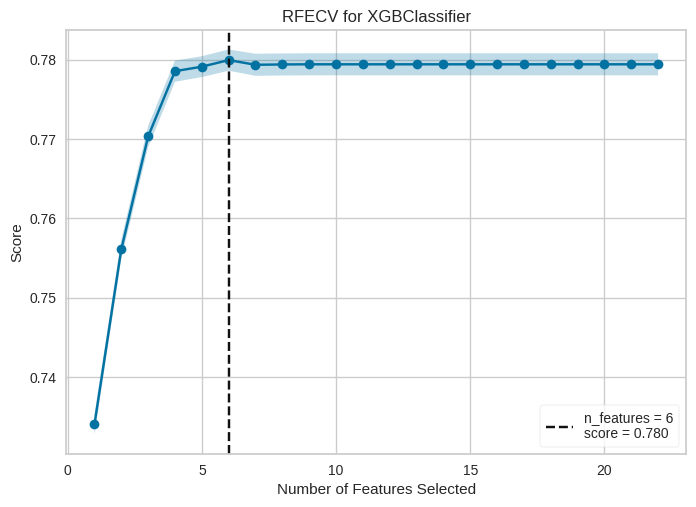

In [28]:
# Record the start time
start_time = time.time()

# Initialize the Decision Tree estimator using XGBoost
estimator = xgb.XGBClassifier(
    objective='binary:logistic',   
    booster='gbtree',
    n_estimators=1,
    tree_method='hist',
    max_depth=6,
    nthread=7,
    random_state=42
)

# Use RFECV from Yellowbrick with the settings, reduced CV and larger step
visualizer = RFECV(estimator, step=1, cv=5, scoring ='roc_auc')

# Assuming X_train_scaled has been pre-scaled. If not, scale it first.
visualizer.fit(X_train_subset_scaled, y_train_subset)

# Set the title, x-label, and y-label after fitting the visualizer
plt.title("RFECV - Feature Selection with Decision Tree")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score")
plt.savefig(results_folder / "RFECV_DT_V02.png", dpi=300)

# Show the visualizer
visualizer.show(outpath= results_folder / "RFECV.png")

# Record the end time
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"RFECV took {duration:.2f} seconds.")



In [29]:
# Print the features selected by RFECV
feature_names = X_train.columns

# Map the selected features to the original column names
selected_features = [feature for mask, feature in zip(visualizer.support_, feature_names) if mask]

print("Selected Features:", selected_features)

Selected Features: ['Age_Band', 'ICD10_Chapter_Code_XIV', 'ICD10_Chapter_Code_XIX', 'ICD10_Chapter_Code_XVIII', 'TFC_180', 'TFC_420']


# Step 8: Hyperparameter Tuning with Randomized Search CV

After feature selection, use RandomizedSearchCV for hyperparameter tuning on the training set. The cross-validation within RandomizedSearchCV uses multiple train-validation splits of the training data.

Use only 10% percent of the training set to perform hyperparameter tuning due to insuffient CPU and GPU resources. The training set is very high after oversampling.

In [30]:
# Extract columns from the scaled and resampled training set using the list of selected features
selected_feature_indices = [X_train.columns.get_loc(feature) for feature in selected_features]
X_train_selected_scaled = X_train_scaled[:, selected_feature_indices]

In [31]:
# Filter X_train_subset_scaled with the best features
X_train_selected_subset_scaled = X_train_subset_scaled[:, selected_feature_indices]

# Define the hyperparameter grid for DecisionTree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.01, 0.1, 0.2, 0.3]
}

# Record the start time
start_time = time.time()

clf_dt = DecisionTreeClassifier(random_state=42)

# Use RandomizedSearchCV to find the best hyperparameters for DecisionTree
random_search_dt = RandomizedSearchCV(
    clf_dt, param_distributions=param_grid_dt, n_iter=50, scoring='roc_auc', n_jobs=7, cv=5, random_state=42, verbose = True)

random_search_dt.fit(X_train_selected_subset_scaled, y_train_subset)

# Save the cv_results_ to a DataFrame and then to a CSV file
cv_results_df = pd.DataFrame(random_search_dt.cv_results_)
cv_results_df.to_csv(results_folder /'cv_results.csv', index=False)

# Print results
print("Best parameters for DecisionTree:", random_search_dt.best_params_)
print("Best ROC-AUC score for DecisionTree:", random_search_dt.best_score_)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Hyperparameter tuning for DecisionTree took {duration:.2f} seconds.")

# Save the model
dump(random_search_dt, results_folder / 'random_search_model.joblib')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for DecisionTree: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'gini', 'ccp_alpha': 0.0}
Best ROC-AUC score for DecisionTree: 0.7862611212767437
Hyperparameter tuning for DecisionTree took 72.14 seconds.


['DT_folder/Version 2/Model 3/random_search_model.joblib']

# Step 9: Train the whole dataset with best hyperparameters


In [32]:

# Extracting selected features for training, validation, and test sets:
X_val_selected_scaled = X_val_scaled[:, selected_feature_indices]
X_test_selected_scaled = X_test_scaled[:, selected_feature_indices]


In [33]:
# Define the best hyperparameters
best_params = random_search_dt.best_params_

# Record the start time
start_time = time.time()

# Train a DT model using the best hyperparameters on the training set
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train_selected_scaled, y_train_resampled)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Training for DT took {duration:.2f} seconds.")


Training for DT took 9.94 seconds.


# Step 10: Predict and Evaluate on Validation Set

In [34]:
# Record the start time
start_time = time.time()

y_val_pred = best_model.predict(X_val_selected_scaled)
y_val_prob = best_model.predict_proba(X_val_selected_scaled)[:, 1]  # Probabilities for the positive class

# Evaluate the performance on the validation set using multiple metrics
val_metrics = {
    'Accuracy': accuracy_score(y_val, y_val_pred),
    'ROC-AUC': roc_auc_score(y_val, y_val_prob),
    'F1 Score': f1_score(y_val, y_val_pred),
    'Precision': precision_score(y_val, y_val_pred),
    'Recall': recall_score(y_val, y_val_pred)
}

print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value}")


Validation Metrics:
Accuracy: 0.6566983696862339
ROC-AUC: 0.7618034431493748
F1 Score: 0.7805643399596187
Precision: 0.9758073834663272
Recall: 0.6504249762940861


# Step 11: Final Model Training and Test Evaluation

Finally, we train on the combined train+validation data and test on the test set.

In [35]:
# Combine the training and validation sets
X_combined = np.concatenate([X_train_selected_scaled, X_val_selected_scaled], axis=0)
y_combined = np.concatenate([y_train_resampled, y_val], axis=0)

# Record the start time
start_time = time.time()

# Train the final model on the combined set
final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_combined, y_combined)

# Record the end time
end_time = time.time()
duration = end_time - start_time

print(f"Training Decision Tree took {duration:.2f} seconds.")

Training Decision Tree took 11.92 seconds.


In [36]:
dump(final_model, results_folder / 'final_model_DT.joblib')

['DT_folder/Version 2/Model 3/final_model_Logistic.joblib']

# Step 12: Predict on test set

In [37]:
# Predict on the test set
y_test_pred = final_model.predict(X_test_selected_scaled)
y_test_prob = final_model.predict_proba(X_test_selected_scaled)[:, 1]  # Probabilities for the positive class

# Evaluate the performance on the test set using multiple metrics
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'ROC-AUC': roc_auc_score(y_test, y_test_prob),
    'F1 Score': f1_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred)
}

print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Test Metrics:
Accuracy: 0.6633192425011777
ROC-AUC: 0.7623289399064682
F1 Score: 0.7858505844704936
Precision: 0.9752479547712628
Recall: 0.6580537085084245
Confusion Matrix:
[[  86965   29920]
 [ 612579 1178869]]


# Step 13: Save the metrics

In [38]:
# Save all metrics in a csv file

# Convert the metrics to a DataFrame
metrics_df = pd.DataFrame(list(test_metrics.items()), columns=['Metric', 'Value'])

# Save to CSV
output_path = results_folder / "Model3_Performance_metrics.csv"
metrics_df.to_csv(output_path, index=False)

print(f"Metrics saved to: {output_path}")

Metrics saved to: DT_folder/Version 2/Model 3/Model3_Performance_metrics.csv


# ROC-AUC Curve

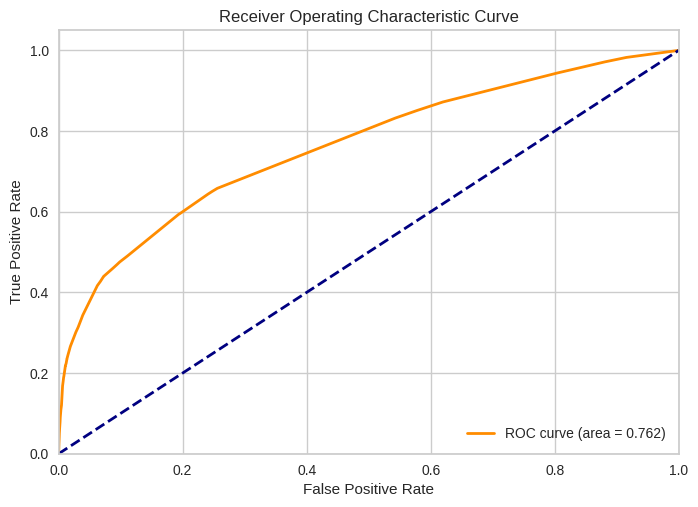

In [39]:
# y_test_prob contains the predicted probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.savefig(results_folder / "roc_auc.png", dpi=300)
plt.show()


# Precision-Recall Curve

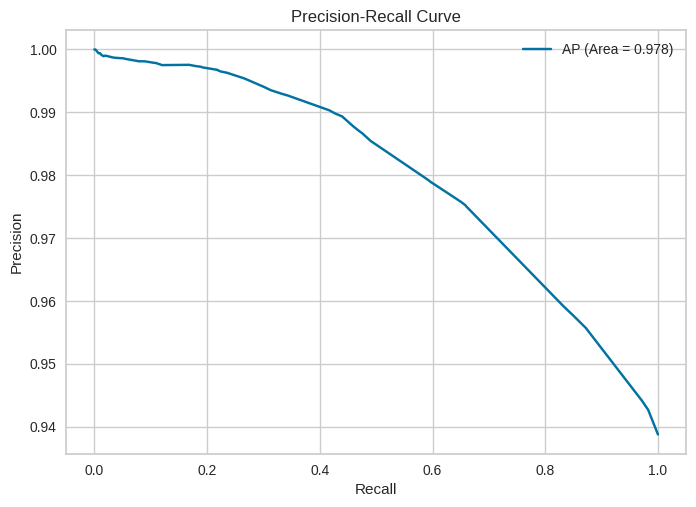

In [40]:
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
average_precision = average_precision_score(y_test, y_test_prob)

plt.figure()
plt.plot(recall, precision, label='AP (Area = %0.3f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.savefig(results_folder / "precision_recall.png", dpi=300)
plt.show()

# Calculate Error

In [41]:
# Predict on training set
y_combined_pred = final_model.predict(X_combined)
combined_accuracy = accuracy_score(y_combined, y_combined_pred)
combined_error = 1 - combined_accuracy

# Predict on validation set
y_val_pred = final_model.predict(X_val_selected_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_error = 1 - val_accuracy

# Predict on test set
y_test_pred = final_model.predict(X_test_selected_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

print(f"Combined Error: {combined_error:.3f}")
print(f"Validation Error: {val_error:.3f}")
print(f"Test Error: {test_error:.3f}")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Combined Error', 'Validation Error', 'Test Error'],
    'Value': [combined_error, val_error, test_error]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv(results_folder / 'Model_Metrics.csv', index=False)

Combined Error: 0.286
Validation Error: 0.336
Test Error: 0.337


# Feature Importance



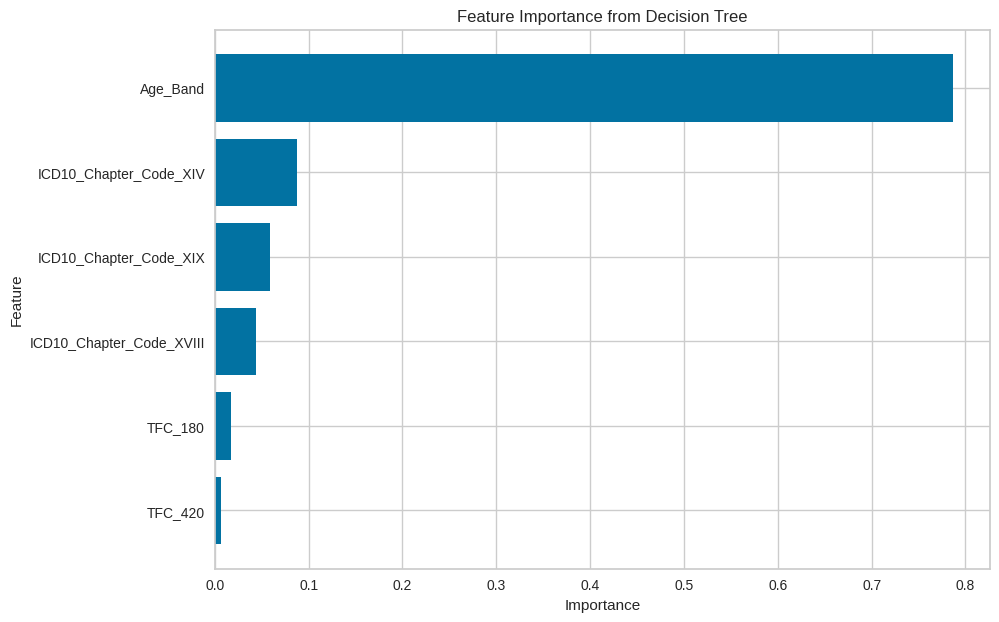

In [42]:
# Retrieve Feature Importance
importances = final_model.feature_importances_

# Match Feature Importance to Feature Names:
feature_names = [X_train.columns[i] for i in selected_feature_indices]

# Sort Features by Importance:
sorted_idx = np.argsort(importances)[::-1]

# Plot

plt.figure(figsize=(10, 7))
plt.barh(feature_names, importances[sorted_idx])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance from Decision Tree")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig(results_folder / "Feature_Importance.png", dpi=300)
plt.show()


In [43]:
# Create a DataFrame to hold feature names and their corresponding importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame based on the importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Save the DataFrame to a CSV file
feature_importance_df.to_csv(results_folder / 'Feature_Importance.csv', index=False)

In [44]:
# tree.plot_tree(best_model)
# plt.savefig(results_folder / "Tree.png", dpi=300)
# plt.show()
